# MMM Data Exploration and Analysis

This notebook demonstrates the exploration and analysis of real MMM data with mediation assumptions.


In [1]:
# Import necessary libraries
import sys
import os

# Add src directory to path
current_dir = os.getcwd()
src_path = os.path.join(current_dir, '..', 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import our custom modules
try:
    from data_preparation import DataPreparator
    from utils import set_random_seed
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running this notebook from the notebooks/ directory")
    print("Current working directory:", os.getcwd())
    print("Python path:", sys.path)
    raise

# Set random seed for reproducibility
set_random_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Load Real MMM Data

We'll work with the actual 2-year weekly MMM dataset with the following characteristics:
- **Mediation Assumption**: Google spend mediates the relationship between social channels and revenue
- **Real Data**: Actual media spend, revenue, and business metrics
- **Time Period**: 2 years of weekly data (2023-09-17 to 2025-09-07)
- **Zero-spend Periods**: Real periods with no media spend
- **Business Variables**: Price, promotions, followers, email/SMS


In [2]:
# Load the real MMM dataset
data = pd.read_csv('../data/raw/Assessment 2 - MMM Weekly.csv')

# Convert week column to datetime
data['date'] = pd.to_datetime(data['week'])
data = data.drop('week', axis=1)  # Remove the original week column

# Rename columns to match our expected format
data = data.rename(columns={
    'emails_send': 'email_volume',
    'sms_send': 'sms_volume',
    'social_followers': 'followers'
})

print(f"Loaded dataset shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")
print(f"Columns: {list(data.columns)}")
print(f"Total weeks: {len(data)}")


Loaded dataset shape: (104, 12)
Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Columns: ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'followers', 'average_price', 'promotions', 'email_volume', 'sms_volume', 'revenue', 'date']
Total weeks: 104


In [3]:
# Display first few rows
print("First 10 rows of the dataset:")
data.head(10)


First 10 rows of the dataset:


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,followers,average_price,promotions,email_volume,sms_volume,revenue,date
0,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,2023-09-17
1,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,2023-09-24
2,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,2023-10-01
3,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,2023-10-08
4,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,2023-10-15
5,4195.29,3385.89,0.00,3438.69,0.00,0,102.55,0,116640,25808,141742.69,2023-10-22
6,4788.44,4012.79,0.00,3103.79,838.75,0,107.29,0,109633,15211,42968.41,2023-10-29
7,6862.08,0.00,0.00,2852.10,2230.06,0,110.24,0,135573,13775,1.00,2023-11-05
8,5792.88,0.00,0.00,3003.76,1598.50,0,108.45,0,114713,22805,23117.23,2023-11-12
9,5881.88,0.00,2735.20,3705.38,2952.89,0,108.59,0,146399,21043,26904.34,2023-11-19


In [4]:
# Basic statistics
print("Dataset Statistics:")
print("=" * 50)
data.describe()


Dataset Statistics:


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,followers,average_price,promotions,email_volume,sms_volume,revenue,date
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104
mean,5346.302500,1543.866442,955.632212,1019.342885,747.465000,72414.509615,99.962500,0.211538,120691.067308,23623.115385,49053.945096,2024-09-11 12:00:00
min,2456.940000,0.000000,0.000000,0.000000,0.000000,0.000000,87.560000,0.000000,68655.000000,10460.000000,1.000000,2023-09-17 00:00:00
25%,4538.977500,0.000000,0.000000,0.000000,0.000000,38318.250000,94.207500,0.000000,102971.500000,19252.500000,474.852500,2024-03-15 06:00:00
50%,5293.780000,0.000000,0.000000,0.000000,0.000000,81109.500000,99.490000,0.000000,120237.000000,22459.500000,972.065000,2024-09-11 12:00:00
75%,6033.325000,3374.205000,2487.172500,2395.350000,1705.872500,110281.250000,105.395000,0.000000,136594.000000,28107.000000,45773.732500,2025-03-10 18:00:00
max,9325.180000,6083.160000,4143.250000,3877.990000,3126.040000,143477.000000,113.380000,1.000000,185460.000000,40153.000000,398453.530000,2025-09-07 00:00:00
std,1168.961177,1863.350279,1376.993132,1349.184250,982.088273,47778.448985,6.496186,0.410377,25158.181476,6661.362493,93329.607019,NaN


## 2. Data Quality Assessment

Let's examine the data quality and identify any issues:


In [5]:
# Check for missing values
missing_data = data.isnull().sum()
print("Missing values by column:")
print(missing_data[missing_data > 0])

if missing_data.sum() == 0:
    print("\n✅ No missing values found!")
else:
    print(f"\n⚠️ Total missing values: {missing_data.sum()}")


Missing values by column:
Series([], dtype: int64)

✅ No missing values found!


In [6]:
# Check for zero-spend periods
media_cols = [col for col in data.columns if 'spend' in col.lower()]
print("Zero-spend periods by channel:")
for col in media_cols:
    zero_count = (data[col] == 0).sum()
    zero_pct = (zero_count / len(data)) * 100
    print(f"{col}: {zero_count} periods ({zero_pct:.1f}%)")


Zero-spend periods by channel:
facebook_spend: 0 periods (0.0%)
google_spend: 59 periods (56.7%)
tiktok_spend: 68 periods (65.4%)
instagram_spend: 63 periods (60.6%)
snapchat_spend: 63 periods (60.6%)


## 3. Time Series Analysis

Let's examine the time series characteristics of our key variables:


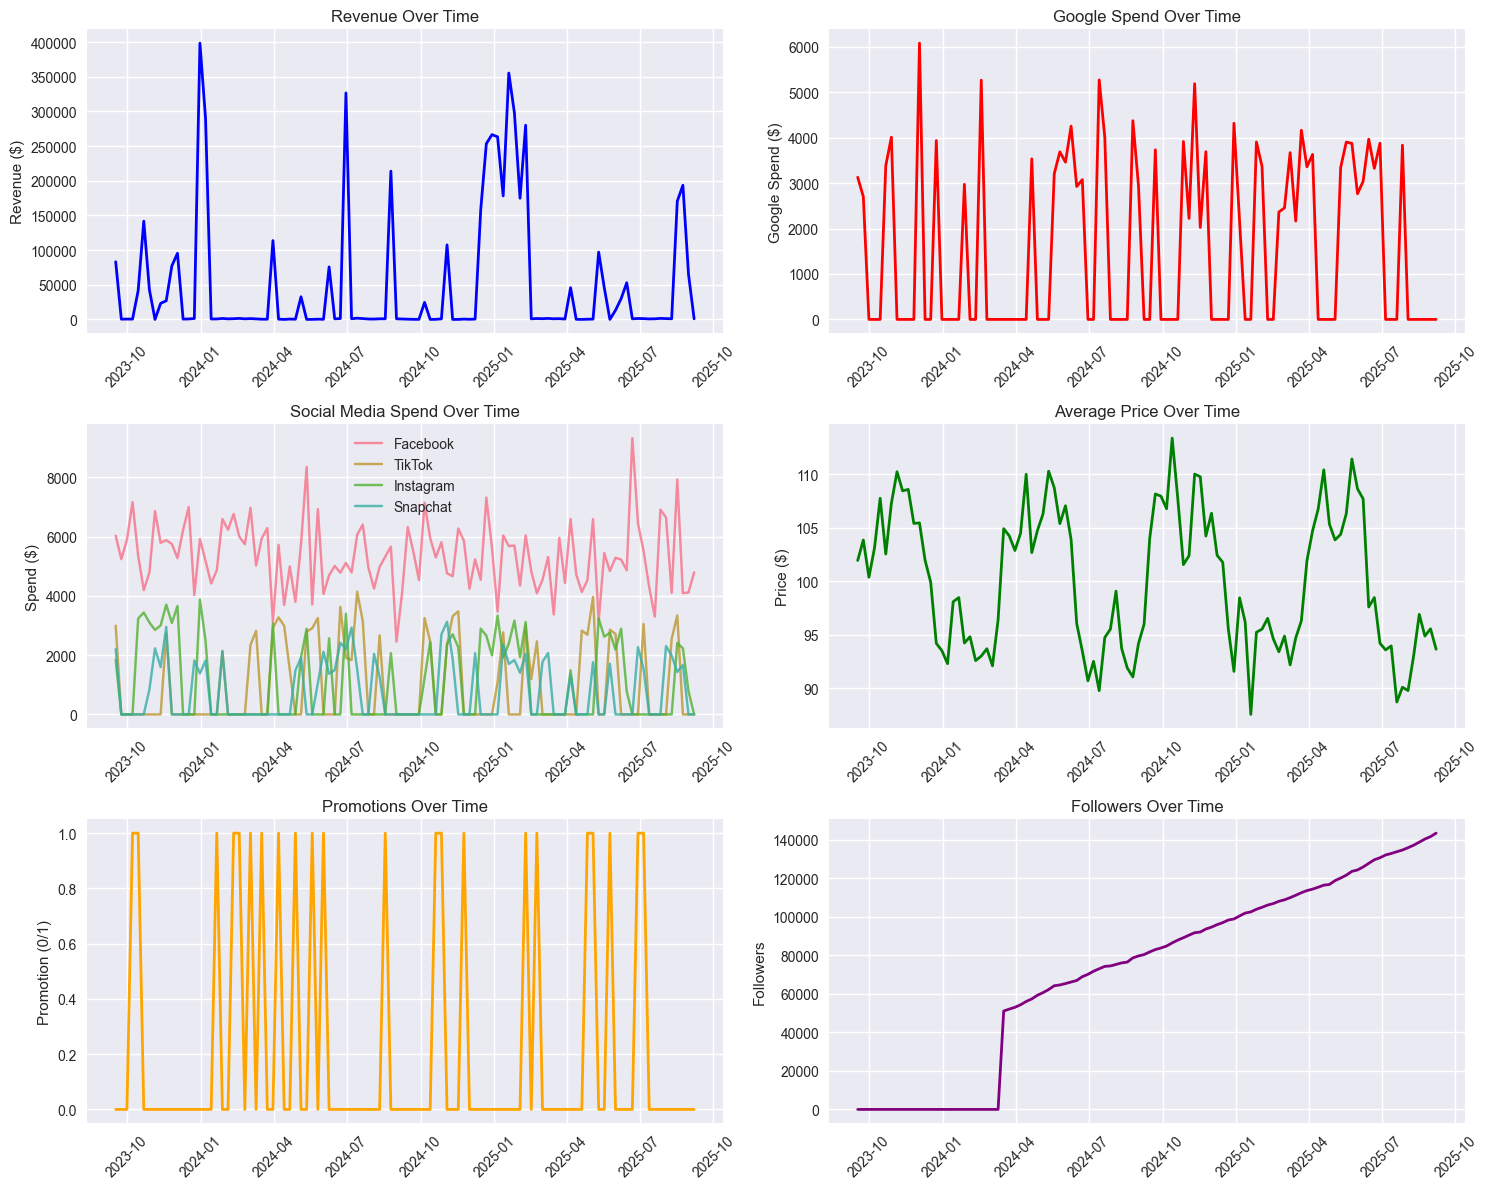

In [7]:
# Plot time series of key variables
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()

# Revenue
axes[0].plot(data['date'], data['revenue'], color='blue', linewidth=2)
axes[0].set_title('Revenue Over Time')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)

# Google Spend
axes[1].plot(data['date'], data['google_spend'], color='red', linewidth=2)
axes[1].set_title('Google Spend Over Time')
axes[1].set_ylabel('Google Spend ($)')
axes[1].tick_params(axis='x', rotation=45)

# Social Media Spend
axes[2].plot(data['date'], data['facebook_spend'], label='Facebook', alpha=0.8)
axes[2].plot(data['date'], data['tiktok_spend'], label='TikTok', alpha=0.8)
axes[2].plot(data['date'], data['instagram_spend'], label='Instagram', alpha=0.8)
axes[2].plot(data['date'], data['snapchat_spend'], label='Snapchat', alpha=0.8)
axes[2].set_title('Social Media Spend Over Time')
axes[2].set_ylabel('Spend ($)')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# Average Price
axes[3].plot(data['date'], data['average_price'], color='green', linewidth=2)
axes[3].set_title('Average Price Over Time')
axes[3].set_ylabel('Price ($)')
axes[3].tick_params(axis='x', rotation=45)

# Promotions
axes[4].plot(data['date'], data['promotions'], color='orange', linewidth=2)
axes[4].set_title('Promotions Over Time')
axes[4].set_ylabel('Promotion (0/1)')
axes[4].tick_params(axis='x', rotation=45)

# Followers
axes[5].plot(data['date'], data['followers'], color='purple', linewidth=2)
axes[5].set_title('Followers Over Time')
axes[5].set_ylabel('Followers')
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Correlation Analysis

Let's examine the relationships between variables:


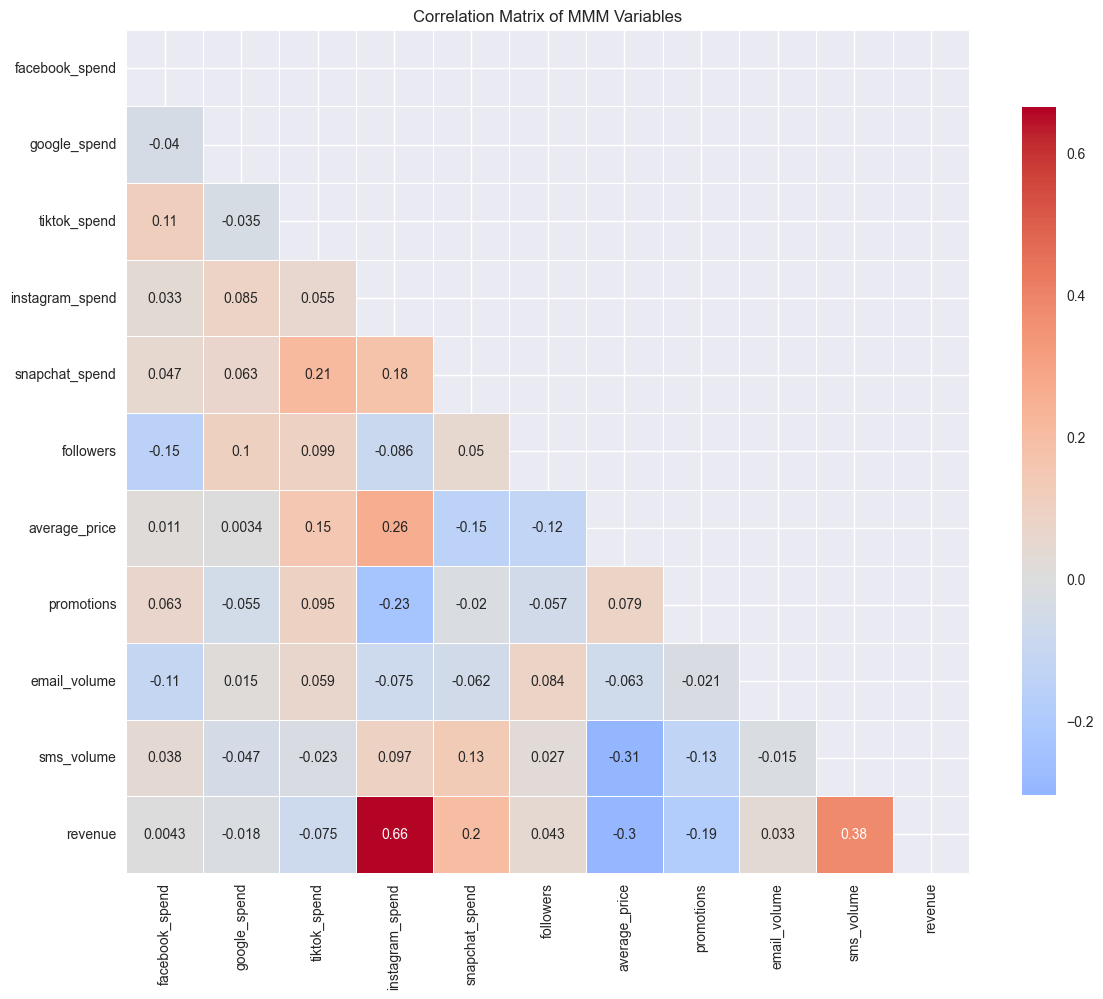

In [8]:
# Calculate correlation matrix
correlation_matrix = data.select_dtypes(include=[np.number]).corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of MMM Variables')
plt.tight_layout()
plt.show()


In [9]:
# Focus on revenue correlations
revenue_correlations = correlation_matrix['revenue'].sort_values(ascending=False)
print("Correlations with Revenue:")
print(revenue_correlations)


Correlations with Revenue:
revenue            1.000000
instagram_spend    0.664017
sms_volume         0.379761
snapchat_spend     0.198661
followers          0.043269
email_volume       0.032878
facebook_spend     0.004274
google_spend      -0.018018
tiktok_spend      -0.075164
promotions        -0.188793
average_price     -0.295128
Name: revenue, dtype: float64


## 5. Mediation Analysis Preview

Let's examine the mediation assumption - how social channels influence Google spend:


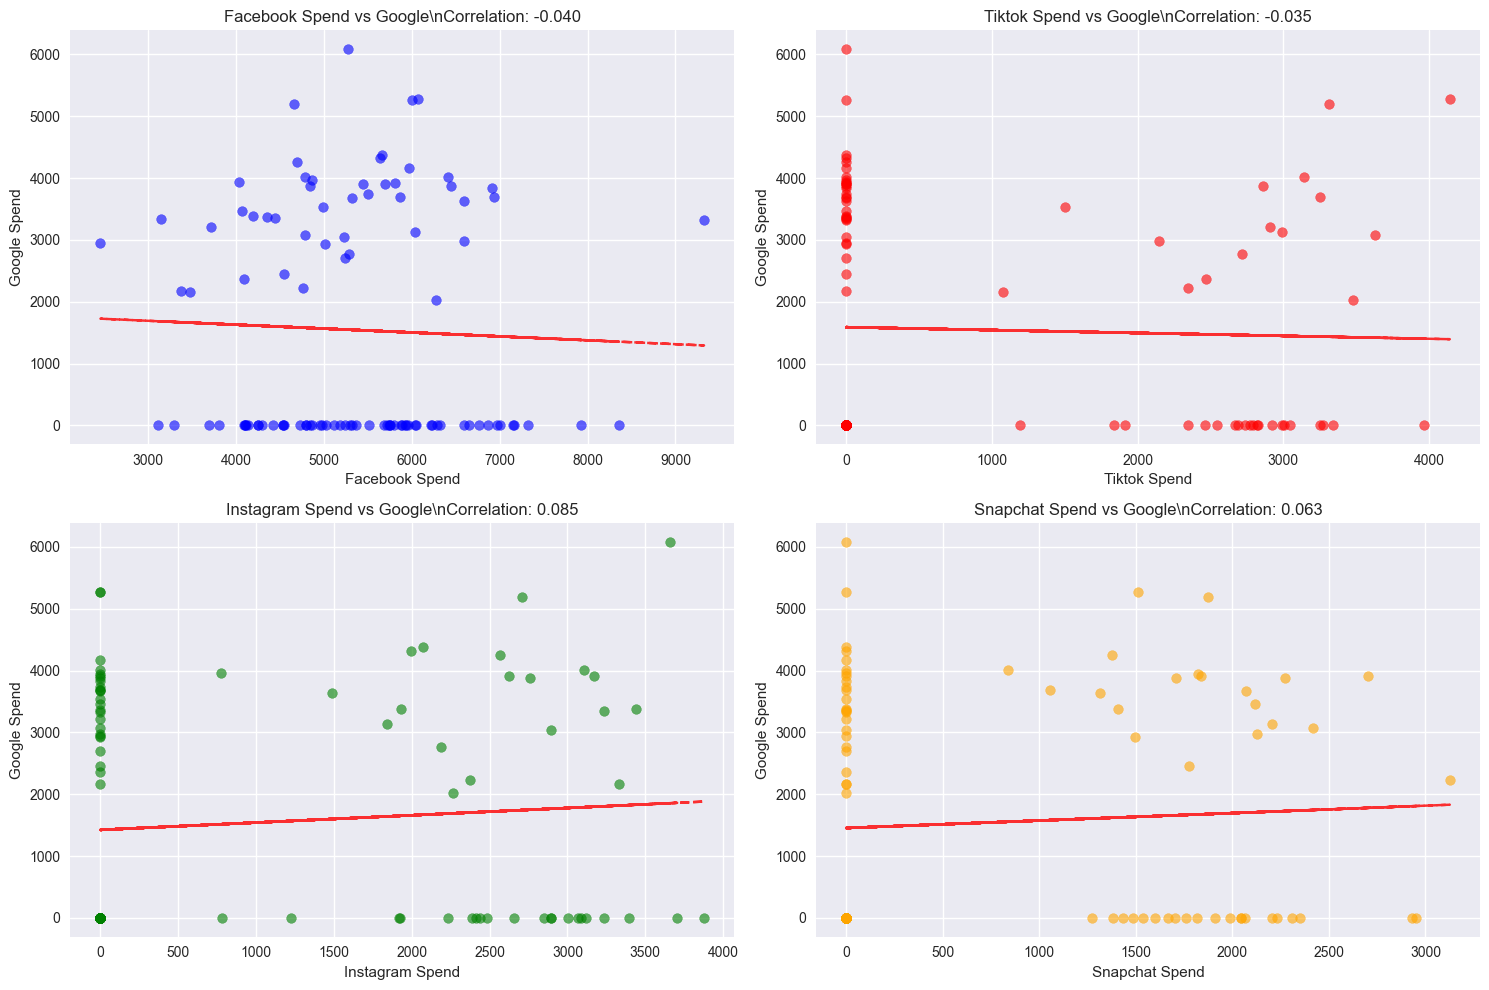

In [10]:
# Scatter plots showing social channels vs Google spend
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

social_channels = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
colors = ['blue', 'red', 'green', 'orange']

for i, (channel, color) in enumerate(zip(social_channels, colors)):
    row = i // 2
    col = i % 2
    
    axes[row, col].scatter(data[channel], data['google_spend'], alpha=0.6, color=color)
    axes[row, col].set_xlabel(f'{channel.replace("_", " ").title()}')
    axes[row, col].set_ylabel('Google Spend')
    
    # Add trend line
    z = np.polyfit(data[channel], data['google_spend'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(data[channel], p(data[channel]), "r--", alpha=0.8)
    
    # Calculate correlation
    corr = data[channel].corr(data['google_spend'])
    axes[row, col].set_title(f'{channel.replace("_", " ").title()} vs Google\\nCorrelation: {corr:.3f}')

plt.tight_layout()
plt.show()


In [11]:
# Calculate mediation strength
print("Mediation Analysis - Social Channels to Google Spend:")
print("=" * 50)

for channel in social_channels:
    # Simple correlation as proxy for mediation strength
    corr = data[channel].corr(data['google_spend'])
    print(f"{channel.replace('_', ' ').title()}: {corr:.3f}")

print("\nGoogle Spend to Revenue:")
google_revenue_corr = data['google_spend'].corr(data['revenue'])
print(f"Google Spend: {google_revenue_corr:.3f}")


Mediation Analysis - Social Channels to Google Spend:
Facebook Spend: -0.040
Tiktok Spend: -0.035
Instagram Spend: 0.085
Snapchat Spend: 0.063

Google Spend to Revenue:
Google Spend: -0.018


## 6. Save Data

Let's save the processed data for use in subsequent notebooks:


In [12]:
# Save the processed data
data.to_csv('../data/raw/mmm_data.csv', index=False)
print("✅ Data saved to ../data/raw/mmm_data.csv")

# Display summary statistics
print("\n📊 Data Summary:")
print(f"- Total weeks: {len(data)}")
print(f"- Date range: {data['date'].min().strftime('%Y-%m-%d')} to {data['date'].max().strftime('%Y-%m-%d')}")
print(f"- Average weekly revenue: ${data['revenue'].mean():,.0f}")
print(f"- Total media spend: ${data[media_cols].sum().sum():,.0f}")
print(f"- Average price: ${data['average_price'].mean():.2f}")
print(f"- Promotion periods: {data['promotions'].sum()} weeks ({data['promotions'].mean()*100:.1f}%)")
print(f"- Total followers: {data['followers'].max():,.0f}")
print(f"- Email volume: {data['email_volume'].mean():,.0f} per week")
print(f"- SMS volume: {data['sms_volume'].mean():,.0f} per week")


✅ Data saved to ../data/raw/mmm_data.csv

📊 Data Summary:
- Total weeks: 104
- Date range: 2023-09-17 to 2025-09-07
- Average weekly revenue: $49,054
- Total media spend: $999,711
- Average price: $99.96
- Promotion periods: 22 weeks (21.2%)
- Total followers: 143,477
- Email volume: 120,691 per week
- SMS volume: 23,623 per week
